In [1]:
import os
import numpy as np
from glob import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,   Dataset
import  matplotlib.pyplot as plt
import cv2
import torchvision.transforms as T

In [2]:
class CamVidDataloader(Dataset):
    def __init__(self, img_path, mask_path, transorm=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.transform = transorm
    
    def __len__(self):
        return len(self.img_path)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256,256))

        mask = cv2.imread(self.mask_path[idx], 0)
        mask = cv2.resize(mask, (256, 256))

        if self.transform:
            img = self.transform(img)
        mask = torch.from_numpy(mask).long()

        return img, mask

In [3]:
dataset_dir = "CamVid"
image_paths = sorted(glob(os.path.join(dataset_dir, "camvid", "images", "*.png")))
mask_paths = sorted(glob(os.path.join(dataset_dir, "camvid", "labels", "*.png")))
print(f"Found {len(image_paths)} images and {len(mask_paths)} masks.")
transform = T.Compose([T.ToTensor()])
dataset = CamVidDataloader(image_paths, mask_paths, transorm= transform)
dataloader = DataLoader(dataset, batch_size = 16, shuffle=True)

Found 701 images and 701 masks.


In [4]:
class Unet(nn.Module):
    def __init__(self, num_classes):
        super(Unet, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )
        self.enc1 = CBR(3,64)
        self.enc2 = CBR(64,128)
        self.enc3 = CBR(128, 256)
        self.enc4 =  CBR(256, 512)

        self.pool =  nn.MaxPool2d(2)
        self.bottleneck = CBR(512, 1024)
        self.upconv4  =  nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256,kernel_size=2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128,kernel_size=2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64,kernel_size=2, stride=2)
        self.dec1 = CBR(128, 64)
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def  forward(self,  x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d4 = self.upconv4(b)
        d4 = self.dec4(torch.cat([d4,e4], dim=1))
        d3 = self.upconv3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = self.upconv2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.upconv1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        out = self.final(d1)
        return out

In [5]:
model = Unet(num_classes=32).cuda()
print(model)

Unet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

In [7]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for img, mask in dataloader:
        img, mask = img.cuda(), mask.cuda()

        test_pred = model(img)
        loss = loss_fn(test_pred, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f"Epoch { epoch+1}/{num_epochs}, Loss: {train_loss/len(dataloader):.4f}")


Epoch 1/20, Loss: 2.7181
Epoch 2/20, Loss: 2.1017
Epoch 3/20, Loss: 1.8344
Epoch 4/20, Loss: 1.6609
Epoch 5/20, Loss: 1.5412
Epoch 6/20, Loss: 1.4449
Epoch 7/20, Loss: 1.3737
Epoch 8/20, Loss: 1.2971
Epoch 9/20, Loss: 1.2292
Epoch 10/20, Loss: 1.1754
Epoch 11/20, Loss: 1.1247
Epoch 12/20, Loss: 1.0782
Epoch 13/20, Loss: 1.0352
Epoch 14/20, Loss: 0.9957
Epoch 15/20, Loss: 0.9515
Epoch 16/20, Loss: 0.9121
Epoch 17/20, Loss: 0.8787
Epoch 18/20, Loss: 0.8531
Epoch 19/20, Loss: 0.8199
Epoch 20/20, Loss: 0.7854


In [27]:
model.eval()
imgs, masks = next(iter(dataloader))
imgs = imgs.cuda()
with torch.no_grad():
    preds = torch.argmax(model(imgs), dim=1).cpu()

In [ ]:
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)

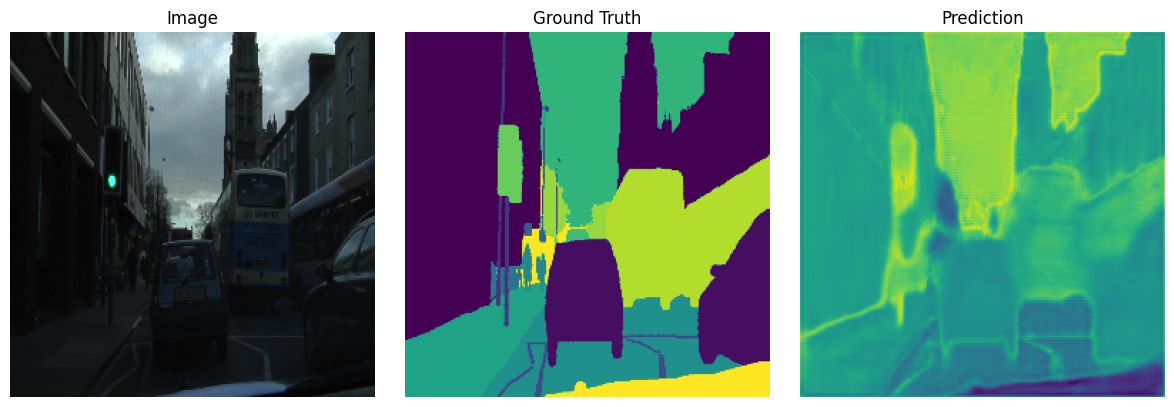

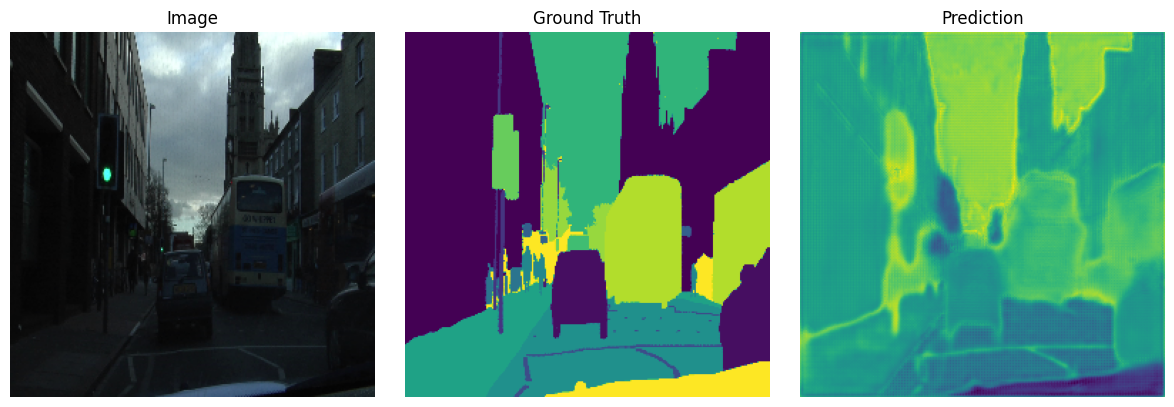

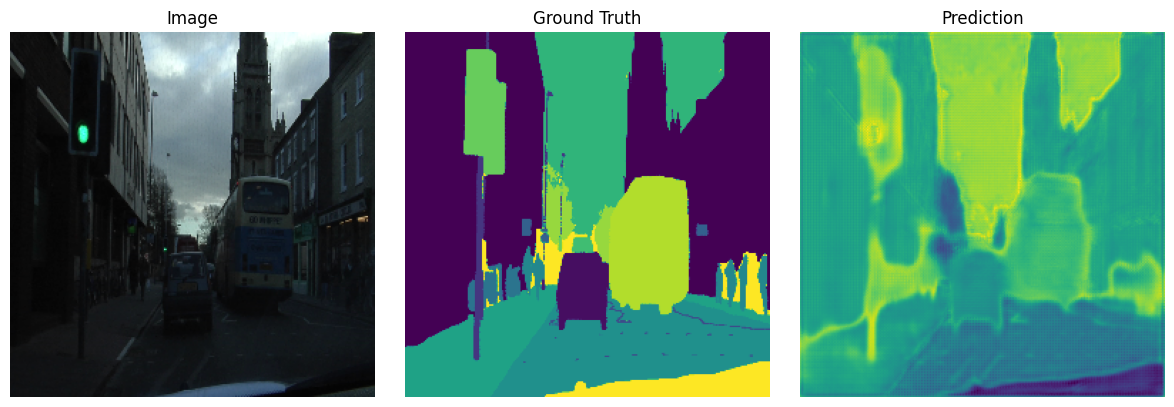

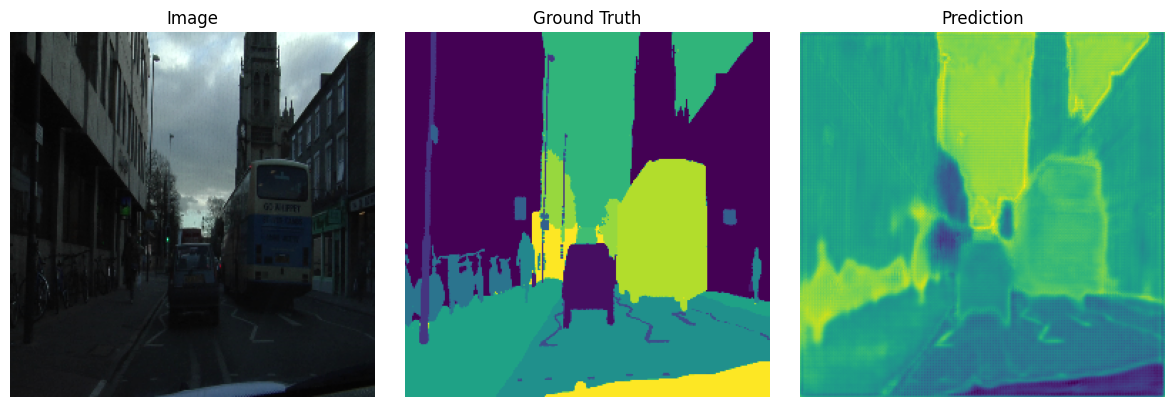

: 

In [ ]:
import matplotlib.pyplot as plt
img_idx = 0
for i, (img, mask) in enumerate(val_loader):
    if i == 4: 
        break 

    pred = model(img.to("cuda")).cpu()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(img[img_idx].permute(1, 2, 0).cpu())  
    axs[0].set_title("Image")

    axs[1].imshow(mask[img_idx].squeeze().cpu())  
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred[0, 0].detach().cpu().numpy())  
    axs[2].set_title("Prediction")

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
